### Modeling

Model Training, Hyperparameter Tuning, and Evaluation

In [1]:
import os, subprocess
import pickle
import warnings
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np

# modeling/experimentation
import mlflow
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# to load parameters of the experiments
from kedro.config import ConfigLoader

# utils
import multiprocessing as mp
from joblib import Parallel, delayed
from pandas import IndexSlice as idx
from IPython.display import display

# viz
import seaborn as sns
import shap
import matplotlib.pyplot as plt

# experiments
import experiments.noaa.machine_learning as ml_experiments

# local utils and other imports
from spatial_interpolation import data, utils
from spatial_interpolation.utils.modeling import (
    tweak_features,
    fit_estimator_with_params,
    compute_metrics,
)
from spatial_interpolation.utils.experiments import conf 
from spatial_interpolation.data.load_data import get_ml_workspace
from spatial_interpolation.utils import tqdm_joblib

# configuration
import dotenv
warnings.simplefilter(action='ignore', category=FutureWarning)
dotenv.load_dotenv()

True

In [4]:
# Track the experiment with MLFlow
# ws = data.get_ml_workspace(auth="service_principal")
# tracking_uri = ws.get_mlflow_tracking_uri()
# mlflow.set_tracking_uri(tracking_uri)
# mlflow.set_experiment(os.environ.get("MLFLOW_EXPERIMENT_NAME"))

In [3]:
# load features
config_name = "rf_config_set1"
experiment = ml_experiments.NOAAMLTraining(config_name)#, mlflow_tracking_uri=tracking_uri)
config = experiment.get_config()

train_df = pd.concat(
    [pd.read_parquet(f"{config.input.train_dir}/{year}.parquet") for year in range(2011,2022)],
    axis=0).sort_index()
test_df = pd.concat(
    [pd.read_parquet(f"{config.input.eval_dir}/{year}.parquet") for year in range(2011,2022)],
    axis=0).sort_index()

In [4]:
# Make the X and Y train and test sets that will be passed to the model
X_train = train_df.drop(columns=[config.target]).copy()
y_train = train_df[config.target]
X_eval = test_df.drop(columns=[config.target]).copy()
y_eval = test_df[config.target]

X_train, X_eval = tweak_features(
    config.pretrain_funcs,
    X_train, X_eval
)
y_train = y_train.loc[X_train.index]
y_eval = y_eval.loc[X_eval.index]

In [ ]:
available_configs = ml_experiments.NOAAMLTraining.config.get_config()
for config_name in available_configs:
    if config_name in [f"experiment{i}" for i in range(1,4+1)]:
        continue
    experiment_name = ml_experiments.NOAAMLTraining.__name__
    p = subprocess.Popen(["python", "-m", "experiments", experiment_name , config_name])
    print(f"Started experiment {config_name} on process {p.pid}")
    

In [ ]:
config_name = "experiment2"
experiment = ml_experiments.NOAAMLTraining(config_name, mlflow_tracking_uri=None)
preds_df = experiment.run()

In [ ]:
config_name = "experiment3"
experiment = ml_experiments.NOAAMLTraining(config_name, mlflow_tracking_uri=None)
preds_df = experiment.run()

-----

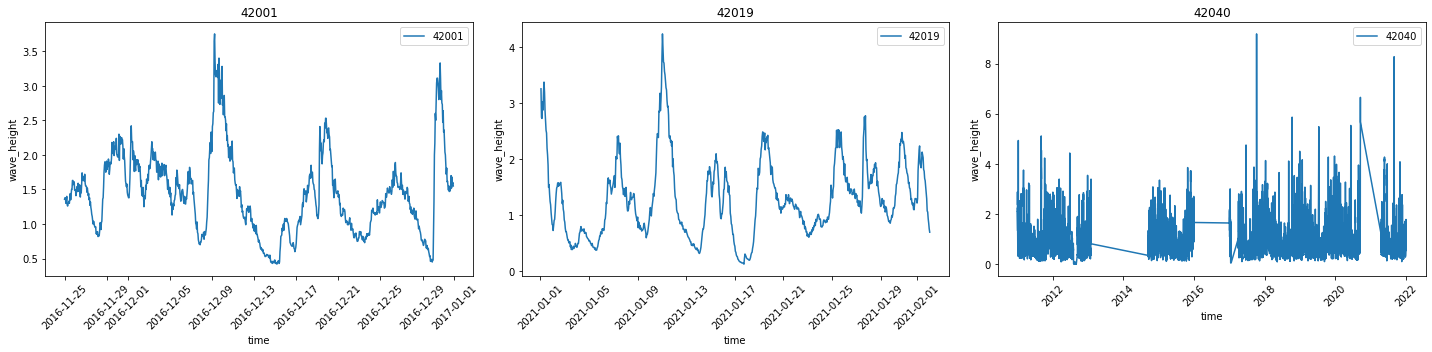

In [74]:
from subplotted import subplotted
locations = y_eval.index.get_level_values("location_id").unique()
for S, ax, location in subplotted(locations, ncols=3, figsize=(20,5)):
    sns.lineplot(data=y_eval.loc[location].reset_index(), x="time", y=y_eval.name, ax=ax, label=location)
    ax.set_title(location)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
else:
    S.fig.tight_layout()

-----

## Hyperparameter Tuning

We'll [Grid Search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 
and [Random Search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) on a subset of the data to tune some of the hyperparameters of our model(s).

In [21]:
# Load Experiment Configuration, search and evaluate hyperparameters
config_name = "rf_config_set1"
experiment = ml_experiments.NOAAMLTraining(config_name)#, mlflow_tracking_uri=tracking_uri)
config = experiment.get_config()
target = config.target

mod = config.model()
fit_params = config.fit_params.to_dict()
if fit_params.get("eval_set"):
    fit_params["eval_set"] = [(X_eval, y_eval)]
search_params = config["param_search"].get("parameters_to_search", {}).to_dict()

for param in config["model_params"]:
    if param not in search_params:
        search_params[param] = [config["model_params"][param]]

parameters_to_search = list(ParameterGrid(search_params))

if config.param_search.strategy == "random":
    assert "size" in config.param_search, "size must be specified for random search"
    print(f"{config.param_search.size}/{len(parameters_to_search)} random search iterations  will be done")
    # choose a random subset of the parameters to search
    parameters_to_search = np.random.choice(parameters_to_search, size=config.param_search.size, replace=False)

# with tqdm_joblib(tqdm(desc="training grid...",total=len(parameters_to_search))) as pbar:
#     results = Parallel(n_jobs=30)(
#         delayed(fit_estimator_with_params)(mod,X=X_train,y=y_train.values,X_eval=X_eval,y_eval=y_eval.values,params=params,fit_params=fit_params)
#         for params in parameters_to_search
#     )

# # get best estimator and results
# best_estimator = min(results,key=lambda d: d["est_best_score"])["estimator"]
# print("Best results:");pprint(min(results,key=lambda d: d["est_best_score"]))
# print("Worst results:");pprint(max(results,key=lambda d: d["est_best_score"]))

# results_df = pd.DataFrame(results).sort_values("est_best_score",ascending=True)
# results_df = pd.concat([results_df,results_df.params.apply(pd.Series)],axis=1)
# results_df.index.name = "round"

# print(results_df.iloc[0]["params"])

100/2376 random search iterations


In [24]:
mod.set_params(**parameters_to_search[0])

TypeError: fit() got an unexpected keyword argument 'bootstrap'

In [68]:
from sklearn.model_selection import RandomizedSearchCV
config_name = "rf_config"
experiment = ml_experiments.NOAAMLTraining(config_name)#, mlflow_tracking_uri=tracking_uri)
config = experiment.get_config() 
target = config.target
mod = config.model()

parameters_to_search = config.parameters_to_search.to_dict() 
random = RandomizedSearchCV(estimator = mod, param_distributions = parameters_to_search, n_iter = 80, cv = 2, verbose=2, random_state=42, n_jobs = 35)
random.fit(X_train, y_train.values)

Fitting 2 folds for each of 80 candidates, totalling 160 fits


In [66]:
random.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

<AxesSubplot:xlabel='learning_rate', ylabel='est_best_score'>

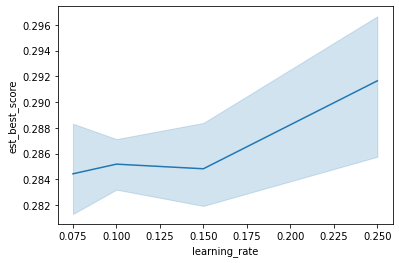

In [62]:
# show param progression
sns.lineplot(x="learning_rate",y="est_best_score",data=results_df)

In [ ]:
# show metrics of best estimator by evaluation set (train, eval)
metrics = {}
for split,y,X in zip(["train","eval"],[y_train,y_eval],[X_train,X_eval]):
    if len(X)==0: continue
    pred = best_estimator.predict(X)
    split_metrics = compute_metrics(y,pred)
    split_metrics_dict = {
        f"{k}_{split}":[v]
        for k,v in split_metrics.to_dict().items()
    }
    metrics.update(split_metrics_dict)
metrics_df = pd.DataFrame(metrics,index=["score"]).rename_axis("metric").T
display(metrics_df.sort_index())

In [ ]:
# show metrics by buoy
preds = []
for split,y,X in zip(["train","eval"],[y_train,y_eval],[X_train,X_eval]):
    if len(X)==0: continue
    pred = best_estimator.predict(X)
    split_metrics = compute_metrics(y.values[:,0],pred)
    split_metrics_dict = {
        f"{k}_{split}":[v]
        for k,v in split_metrics.to_dict().items()
    }
    metrics.update(split_metrics_dict)
    y_preds = pd.DataFrame(dict(true=y.values[:,0],pred=pred),index=X.index)
    y_preds["split"] = split
    preds.append(y_preds)
preds_df = pd.concat(preds,axis=0)
preds_df.groupby("buoy_id").apply(
    lambda g: compute_metrics(g.true,g.pred)
).assign(is_eval=lambda df: df.index.isin(y_eval.index.get_level_values(0)))

In [ ]:
# log metrics
# mlflow.log_metrics({f"best__{row.name}":round(row.score,4) for row in metrics_df.iloc()})

In [ ]:
# log metrics figure
ax = sns.barplot(data=metrics_df.T.round(3))
ax.set(title=f"Best metrics")
ax.bar_label(ax.containers[0])
fig = ax.get_figure();
# mlflow.log_figure(fig,f"best_metrics.png")

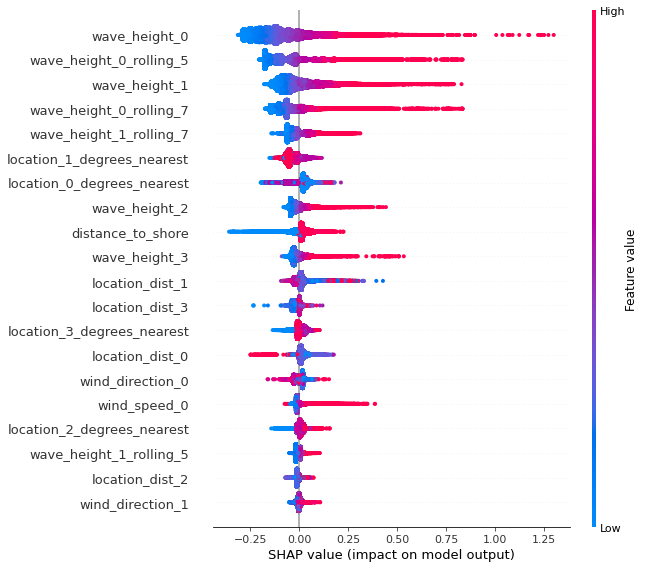

<Figure size 432x288 with 0 Axes>

In [54]:
# log the shap values
shap_values = shap.TreeExplainer(best_estimator).shap_values(X_eval)
fig, ax = plt.subplots(figsize=(18,15),facecolor="white")
shap.summary_plot(shap_values, X_eval)
plt.tight_layout(); fig.set_figwidth(18)
# mlflow.log_figure(fig,f"shap_summary.png")

In [ ]:
# train model with the best parameter on all data
X = pd.concat([X_train,X_eval],axis=0)
y = pd.concat([y_train,y_eval],axis=0)
mod.set_params(**best_estimator.get_params()) # parameters["model_params"]
mod.fit(X,y,**fit_params)
mod

In [ ]:
# end experiment run
mlflow.end_run()